<h1>Transfer Learning with VGG16 using PyTorch</h1>

<h2>MNIST Digit Recognition</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>Transfer Learning with VGG16</b> using PyTorch on MNIST dataset. Transfer learning leverages pre-trained ImageNet features to improve performance on new tasks with less training time.</p>

<h4>PyTorch Transfer Learning Approach:</h4>
<ul>
  <li><b>Pre-trained VGG16</b>: Load with ImageNet weights using torchvision.models</li>
  <li><b>Freeze base layers</b>: Set requires_grad=False for feature extractor</li>
  <li><b>Global Average Pooling</b>: Use nn.AdaptiveAvgPool2d (modern approach)</li>
  <li><b>Custom classifier head</b>: Train only new Dense layers</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Load pre-trained VGG16 from torchvision.models</li>
  <li>✓ Freeze base model layers for feature extraction</li>
  <li>✓ Implement Global Average Pooling with nn.AdaptiveAvgPool2d</li>
  <li>✓ Build custom classification head</li>
  <li>✓ Compare transfer learning vs training from scratch</li>
  <li>✓ Understand parameter efficiency (frozen vs trainable)</li>
</ul>

<hr>

<h3>Architecture</h3>
<pre>
VGG16 Features (frozen)
   ↓
AdaptiveAvgPool2d(1,1)  [GAP]
   ↓
Flatten
   ↓
Linear (128) + ReLU + Dropout(0.5)
   ↓
Linear (10)
</pre>

In [1]:
# Import Libraries
# pip install torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import random
from PIL import Image

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## PART 1: LOAD AND PREPROCESS MNIST DATASET

In [3]:
print("\n[1] Loading MNIST dataset...")

# VGG16 requires 3-channel RGB images with minimum 32x32 size
# We'll resize MNIST to 48x48 and convert to RGB

class MNISTTransform:
    """Custom transform to resize and convert MNIST to RGB for VGG16"""
    def __call__(self, img):
        # Resize to 48x48
        img = transforms.Resize((48, 48))(img)
        # Convert grayscale to RGB (repeat channel 3 times)
        img = img.convert('RGB')
        # Convert to tensor and normalize
        img = transforms.ToTensor()(img)
        # Normalize with ImageNet statistics (required for VGG16)
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])(img)
        return img

# Load datasets with custom transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, 
                               transform=MNISTTransform())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, 
                              transform=MNISTTransform())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image size after preprocessing: 3x48x48")


[1] Loading MNIST dataset...
Training samples: 60000
Test samples: 10000
Image size after preprocessing: 3x48x48


## PART 2: LOAD PRE-TRAINED VGG16 MODEL

In [5]:
print("\n[2] Loading pre-trained VGG16 and building transfer learning model...")

# Load pre-trained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers in the base model
for param in vgg16.features.parameters():
    param.requires_grad = False

print(f"Base model loaded: VGG16 (ImageNet weights)")

frozen_count = sum(not p.requires_grad for p in vgg16.features.parameters())
total_count = sum(1 for _ in vgg16.features.parameters())
print(f"Base model layers frozen: {frozen_count}/{total_count} parameters")


[2] Loading pre-trained VGG16 and building transfer learning model...
Base model loaded: VGG16 (ImageNet weights)
Base model layers frozen: 26/26 parameters


In [6]:
# Build custom classifier with Global Average Pooling
class VGG16TransferLearning(nn.Module):
    def __init__(self, base_model):
        super(VGG16TransferLearning, self).__init__()
        # Use VGG16 features (convolutional layers)
        self.features = base_model.features
        
        # Custom classifier with Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 128)  # VGG16 outputs 512 channels
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Extract features using frozen VGG16
        x = self.features(x)
        
        # Global Average Pooling (replaces Flatten)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        # Custom classification head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = VGG16TransferLearning(vgg16).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Total parameters: 14,781,642
Trainable parameters: 66,954
Frozen parameters: 14,714,688


## PART 3: TRAIN MODEL

In [7]:
print("\n[3] Training model...")

n_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    # Calculate epoch metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{n_epochs}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# Track initial and final loss
initial_loss = train_losses[0]
final_loss = train_losses[-1]

print(f"\nInitial training loss: {initial_loss:.4f}")
print(f"Final training loss:   {final_loss:.4f}")


[3] Training model...
Epoch [1/10] - Train Loss: 0.6042, Train Acc: 81.25% - Val Loss: 0.2511, Val Acc: 92.42%
Epoch [2/10] - Train Loss: 0.2987, Train Acc: 90.75% - Val Loss: 0.1978, Val Acc: 93.65%
Epoch [3/10] - Train Loss: 0.2514, Train Acc: 92.07% - Val Loss: 0.1834, Val Acc: 94.17%
Epoch [4/10] - Train Loss: 0.2290, Train Acc: 92.73% - Val Loss: 0.1696, Val Acc: 94.38%
Epoch [5/10] - Train Loss: 0.2108, Train Acc: 93.30% - Val Loss: 0.1636, Val Acc: 94.56%
Epoch [6/10] - Train Loss: 0.2006, Train Acc: 93.53% - Val Loss: 0.1556, Val Acc: 95.16%
Epoch [7/10] - Train Loss: 0.1919, Train Acc: 93.85% - Val Loss: 0.1467, Val Acc: 95.31%
Epoch [8/10] - Train Loss: 0.1864, Train Acc: 94.00% - Val Loss: 0.1441, Val Acc: 95.42%
Epoch [9/10] - Train Loss: 0.1783, Train Acc: 94.19% - Val Loss: 0.1409, Val Acc: 95.64%
Epoch [10/10] - Train Loss: 0.1715, Train Acc: 94.44% - Val Loss: 0.1380, Val Acc: 95.63%

Initial training loss: 0.6042
Final training loss:   0.1715


## PART 4: EVALUATE MODEL

In [8]:
print("\n[4] Evaluating model on test set...")

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.numpy())

# Convert to numpy arrays
Y_pred_classes = np.array(all_predictions)
Y_test_classes = np.array(all_targets)

# Calculate all metrics
accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
precision = precision_score(Y_test_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes, average='weighted')


print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


[4] Evaluating model on test set...
MODEL PERFORMANCE METRICS
Accuracy:  0.9563
Precision: 0.9566
Recall:    0.9563
F1-Score:  0.9562


## PART 5: VISUALIZATIONS


[5] Generating visualizations...


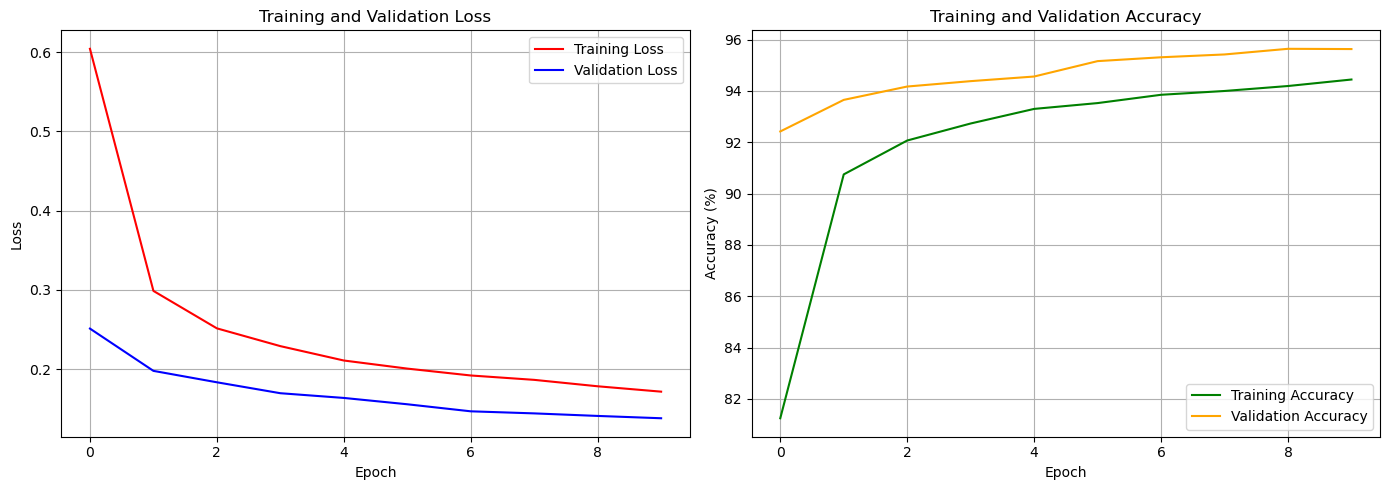

In [9]:
print("\n[5] Generating visualizations...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', color='red')
axes[0].plot(val_losses, label='Validation Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy', color='green')
axes[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

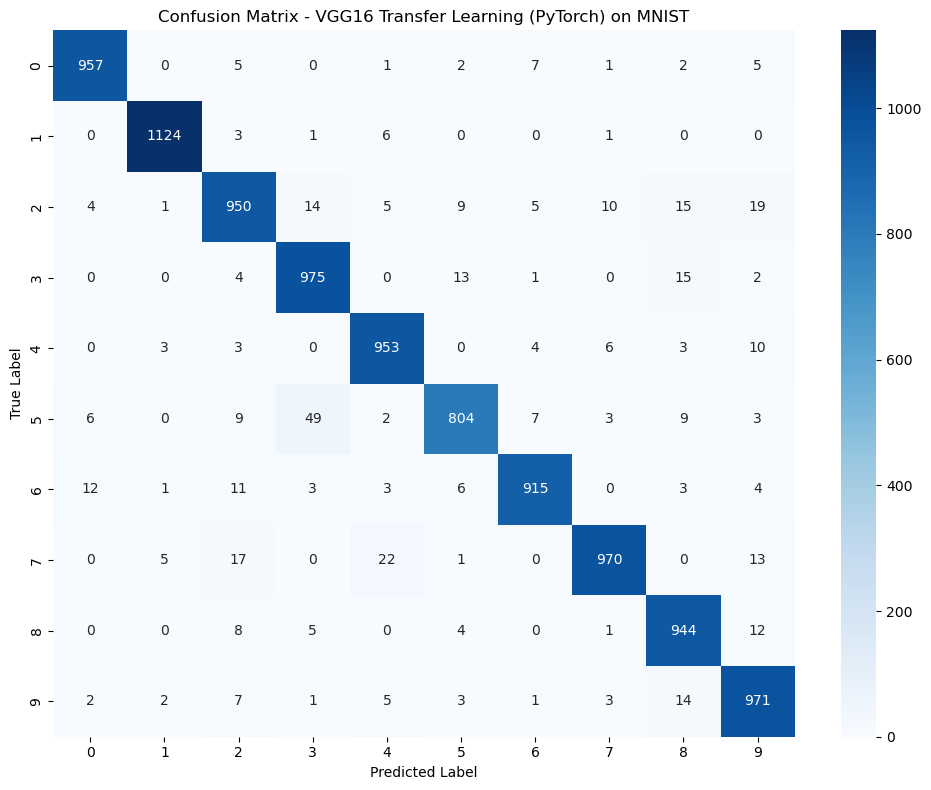

In [10]:
# Confusion Matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - VGG16 Transfer Learning (PyTorch) on MNIST')
plt.tight_layout()

In [11]:

print("CLASSIFICATION REPORT")
print(classification_report(Y_test_classes, Y_pred_classes, 
                          target_names=[str(i) for i in range(10)]))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.93      0.92      0.93      1032
           3       0.93      0.97      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.95      0.90      0.93       892
           6       0.97      0.96      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.94      0.97      0.95       974
           9       0.93      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## PART 6: SAMPLE PREDICTIONS


[6] Visualizing feature maps from VGG16 base model...


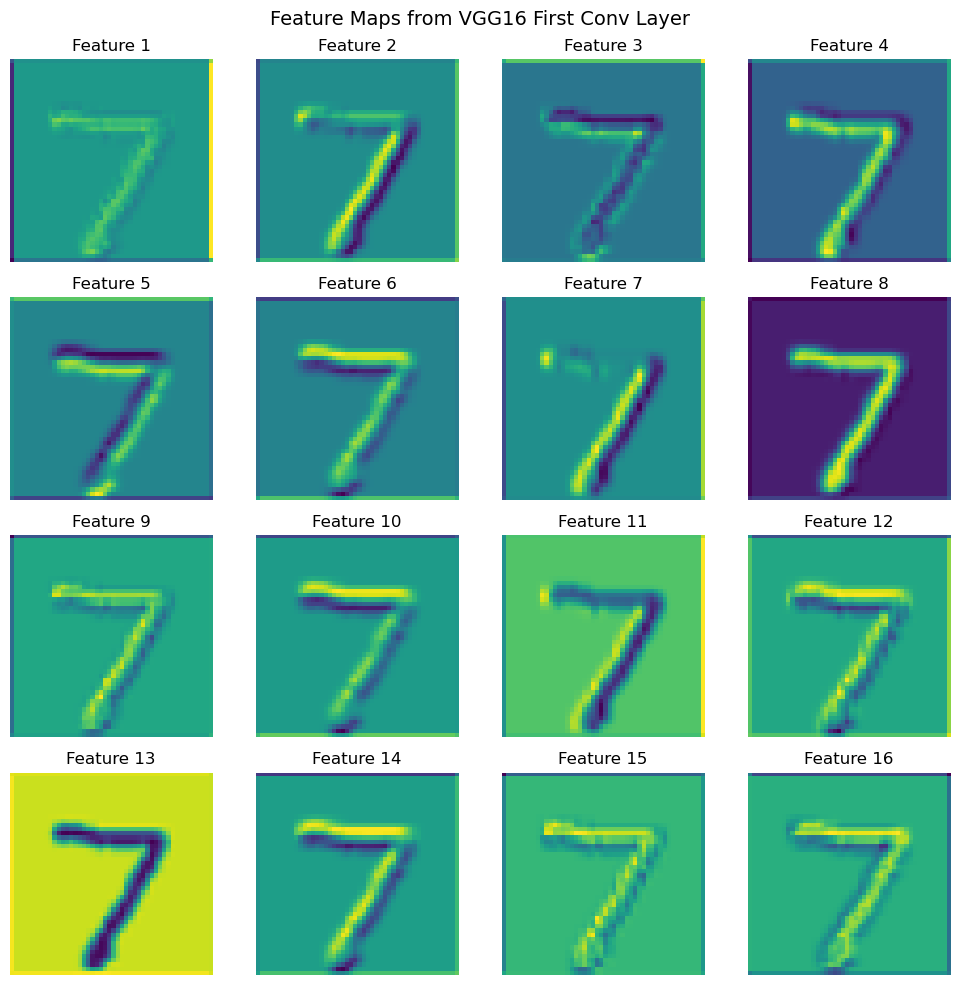

In [12]:
print("\n[6] Visualizing feature maps from VGG16 base model...")

# Get a sample image
dataiter = iter(test_loader)
sample_image, sample_label = next(dataiter)
sample_image = sample_image[0:1].to(device)  # Take first image

# Extract features from first conv layer
model.eval()
with torch.no_grad():
    # Get output of first conv layer
    x = sample_image
    for i, layer in enumerate(model.features):
        x = layer(x)
        if i == 0:  # First conv layer output
            first_conv_output = x
            break

# Plot feature maps
feature_maps = first_conv_output.squeeze(0).cpu().numpy()
n_features = min(16, feature_maps.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < n_features:
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.set_title(f'Feature {i+1}')
    ax.axis('off')

plt.suptitle('Feature Maps from VGG16 First Conv Layer', fontsize=14)
plt.tight_layout()

## PART 7: SAMPLE PREDICTIONS


[7] Sample predictions...


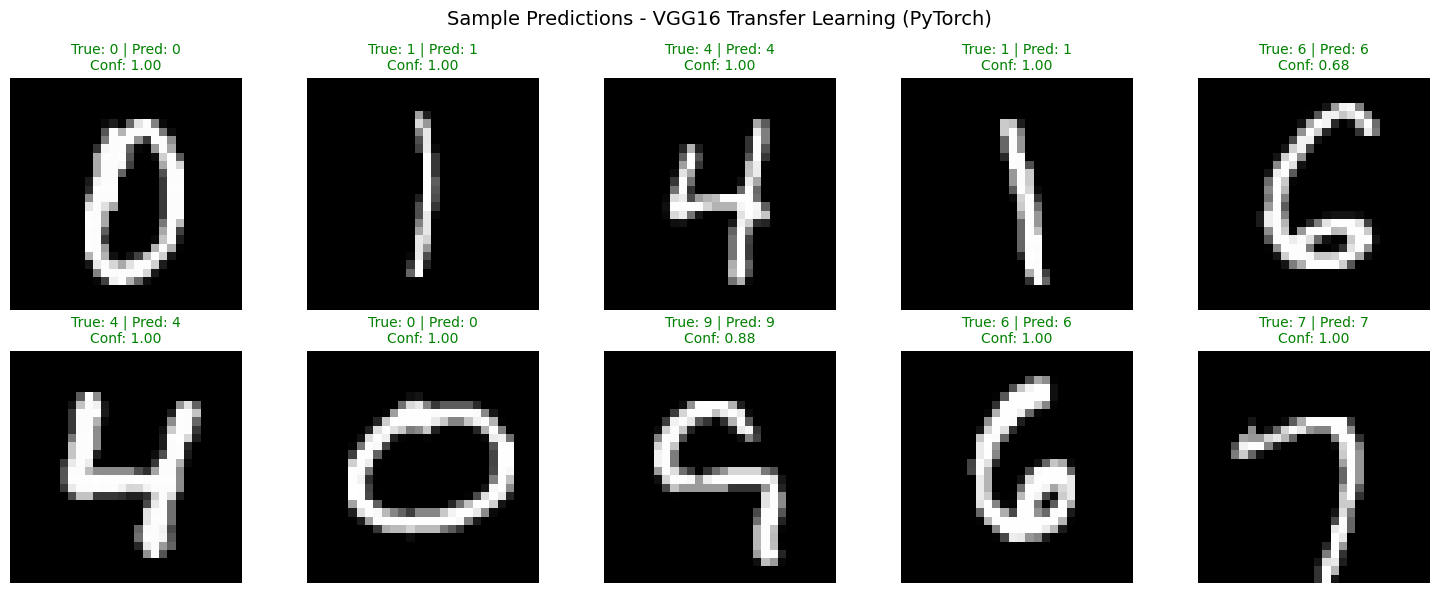

In [13]:
print("\n[7] Sample predictions...")

# Get original MNIST images (without preprocessing) for visualization
test_dataset_orig = datasets.MNIST(root='./data', train=False, download=True,
                                   transform=transforms.ToTensor())
test_loader_orig = DataLoader(test_dataset_orig, batch_size=128, shuffle=False)

# Get a batch
dataiter_orig = iter(test_loader_orig)
images_orig, labels = next(dataiter_orig)

# Get preprocessed images for prediction
dataiter = iter(test_loader)
images_preprocessed, _ = next(dataiter)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images_preprocessed.to(device))
    _, predictions = torch.max(outputs, 1)

# Select 10 random samples
n_samples = 10
indices = np.random.choice(len(images_orig), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in zip(indices, axes.flat):
    # Show original grayscale MNIST image
    img = images_orig[idx].squeeze().cpu().numpy()
    ax.imshow(img, cmap='gray')
    
    true_label = labels[idx].item()
    pred_label = predictions[idx].item()
    
    # Get confidence
    probs = F.softmax(outputs[idx], dim=0)
    confidence = probs[pred_label].item()
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.2f}',
                color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Predictions - VGG16 Transfer Learning (PyTorch)', fontsize=14)
plt.tight_layout()

In [14]:
print("TRANSFER LEARNING COMPLETE (PyTorch)") 
print(f"✓ Base Model: VGG16 (ImageNet weights, frozen)")
print(f"✓ Global Average Pooling: Used")
print(f"✓ Total Parameters: {total_params:,}")
print(f"✓ Trainable Parameters: {trainable_params:,}")
print(f"✓ Test Accuracy: {accuracy:.4f}")
print(f"✓ Training Loss Decreased: {final_loss < initial_loss}")
print(f"✓ Framework: PyTorch {torch.__version__}")

TRANSFER LEARNING COMPLETE (PyTorch)
✓ Base Model: VGG16 (ImageNet weights, frozen)
✓ Global Average Pooling: Used
✓ Total Parameters: 14,781,642
✓ Trainable Parameters: 66,954
✓ Test Accuracy: 0.9563
✓ Training Loss Decreased: True
✓ Framework: PyTorch 2.7.1+cu118


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Student Exercises</h3>

<h4>1. Different Pre-trained Models</h4>
<ul>
  <li><b>ResNet variants</b>: Try ResNet18, ResNet34, ResNet50, ResNet101</li>
  <li><b>MobileNet</b>: Lightweight model for mobile deployment</li>
  <li><b>EfficientNet</b>: State-of-the-art efficiency (torchvision or timm)</li>
  <li><b>DenseNet</b>: Dense connections for feature reuse</li>
</ul>

<h4>2. Fine-Tuning Strategies</h4>
<ul>
  <li><b>Unfreeze layers</b>: Gradually unfreeze last conv blocks</li>
  <li><b>Discriminative learning rates</b>: Lower LR for base, higher for head</li>
  <li><b>Progressive unfreezing</b>: Start frozen, unfreeze during training</li>
  <li><b>Layer-wise LR decay</b>: Different rates for different depths</li>
</ul>

<h4>3. Custom Classifier Variations</h4>
<ul>
  <li>Add more Linear layers (512→256→128→10)</li>
  <li>Try different activation functions (LeakyReLU, GELU)</li>
  <li>Compare <b>AdaptiveAvgPool2d vs Flatten</b> performance</li>
  <li>Experiment with dropout rates (0.2, 0.3, 0.5, 0.7)</li>
</ul>

<h4>4. Training Enhancements</h4>
<ul>
  <li><b>Learning rate scheduling</b>: CosineAnnealingLR, ReduceLROnPlateau</li>
  <li><b>Early stopping</b>: Monitor validation loss</li>
  <li><b>Model checkpointing</b>: Save best weights</li>
  <li><b>TensorBoard logging</b>: Visualize training metrics</li>
</ul>

<h4>5. Apply to New Datasets</h4>
<ul>
  <li>CIFAR-10 (32×32 color, 10 classes)</li>
  <li>Fashion-MNIST (clothing items)</li>
  <li>Your custom image dataset</li>
  <li>Kaggle competitions (Dogs vs Cats, Plant Disease)</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Compare <b>5+ base models</b> on same dataset (accuracy vs speed)</li>
  <li>Achieve best accuracy with <b>minimum trainable parameters</b></li>
  <li>Implement <b>ensemble of transfer learning models</b></li>
  <li>Build <b>multi-task learning</b> head (predict multiple outputs)</li>
</ol>

<hr>
<h4><center>Happy coding</center></h4>